In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import json

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

import shutil

In [2]:
root_dir = './raw-img/'

images_per_folder = {}

for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)

    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        images_per_folder[folder] = num_images

for folder, num_images in images_per_folder.items():
    print(f"Carpeta: {folder}, Cantidad de imágenes: {num_images}")


Carpeta: cane, Cantidad de imágenes: 4863
Carpeta: cavallo, Cantidad de imágenes: 2623
Carpeta: elefante, Cantidad de imágenes: 1446
Carpeta: farfalla, Cantidad de imágenes: 2112
Carpeta: gallina, Cantidad de imágenes: 3098
Carpeta: gatto, Cantidad de imágenes: 1668
Carpeta: mucca, Cantidad de imágenes: 1866
Carpeta: pecora, Cantidad de imágenes: 1820
Carpeta: ragno, Cantidad de imágenes: 4821
Carpeta: scoiattolo, Cantidad de imágenes: 1862


In [3]:
root_dir = './raw-img/'

# Obtener una lista de todas las carpetas en el directorio raíz
folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]

# Crear listas para almacenar las rutas de las imágenes de entrenamiento y prueba
train_dataset = []
test_dataset = []

# Iterar sobre cada carpeta
for folder in folders:
    folder_path = os.path.join(root_dir, folder)
    # Obtener la lista de imágenes en la carpeta
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))]
    # Dividir las imágenes en train y test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    # Agregar las imágenes divididas a los conjuntos de entrenamiento y prueba
    train_dataset.extend([(img_path, folder) for img_path in train_images])
    test_dataset.extend([(img_path, folder) for img_path in test_images])

# Crear directorios para el conjunto de entrenamiento y el conjunto de prueba
train_dir = 'train_dataset'
test_dir = 'test_dataset'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [ ]:
# Copiar imágenes al directorio de entrenamiento y prueba
for dataset, dataset_dir in [(train_dataset, train_dir), (test_dataset, test_dir)]:
    for img_path, label in dataset:
        # Obtener la ruta de la carpeta de destino para esta imagen
        target_folder = os.path.join(dataset_dir, label)
        # Crear la carpeta si no existe
        os.makedirs(target_folder, exist_ok=True)
        # Copiar la imagen al directorio correspondiente
        shutil.copy(img_path, target_folder)

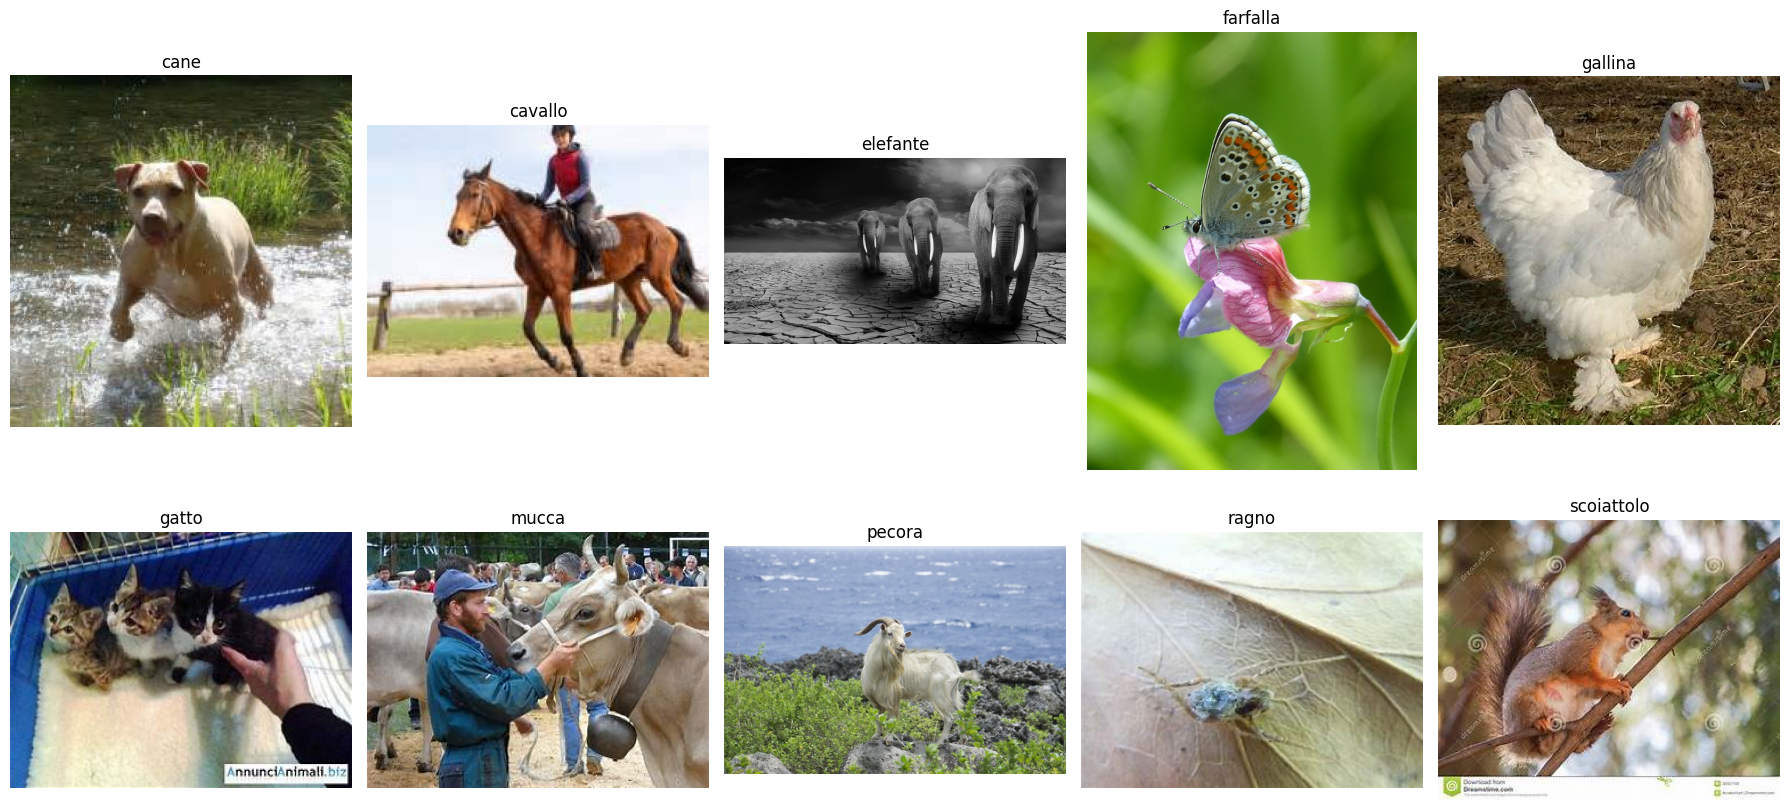

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))

for idx, (folder, images) in enumerate([(folder, train_dataset) for folder in folders]):
    img_path = next(img for img, label in images if label == folder)
    img = Image.open(img_path)

    row_idx = idx // 5
    col_idx = idx % 5
    
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].set_title(folder)
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [5]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# Crear conjuntos de datos ImageFolder
train_set = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(test_dir, transform=data_transforms)

# Crear DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [13]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                   [-1, 10]           5,130
Total params: 5,411,498
Trainable params: 5,411,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.64
Estima

In [7]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    test_loader = data["test"]

    train_writer = tb_writer["train"]
    test_writer = tb_writer["test"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        test_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_test_loss = 0.0
        epoch_test_accuracy = 0.0

        for test_data, test_target in test_loader:
            if torch.cuda.is_available():
                test_data = test_data.to("cuda")
                test_target = test_target.to("cuda")

            output = model(test_data.float())
            epoch_test_loss += criterion(output, test_target).item()
            epoch_test_accuracy += metric(output, test_target).item()

        epoch_test_loss = epoch_test_loss / len(test_loader)
        epoch_test_accuracy = epoch_test_accuracy / len(test_loader)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - test Loss {:.6f} - test Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_test_loss, epoch_test_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            test_writer.add_scalar("loss", epoch_test_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            test_writer.add_scalar("accuracy", epoch_test_accuracy, epoch)
            train_writer.flush()
            test_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = test_loss
    history["valid_acc"] = test_acc

    return history

In [ ]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.0001)
noaug_loss = torch.nn.CrossEntropyLoss()
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_data = {"train": train_loader, "test": test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "test": SummaryWriter(log_dir="data_aug/noaug_test")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                noaug_writer)

In [ ]:
PATH = "./model/naug_conv_model.pt"
torch.save(noaug_conv_model, PATH)

In [ ]:
import json
HISTORY_FILE_PATH = "./output/history.json"
# Writing dictionary to JSON file
with open(HISTORY_FILE_PATH, 'w') as json_file:
    json.dump(history, json_file)

## Aplicar Data Augmentation

In [8]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

aug_train_set = torchvision.datasets.ImageFolder(train_dir, transform=aug_data_transforms)
aug_test_set = torchvision.datasets.ImageFolder(test_dir, transform=aug_data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=32, shuffle=True)
aug_test_loader = torch.utils.data.DataLoader(aug_test_set, batch_size=32, shuffle=True)

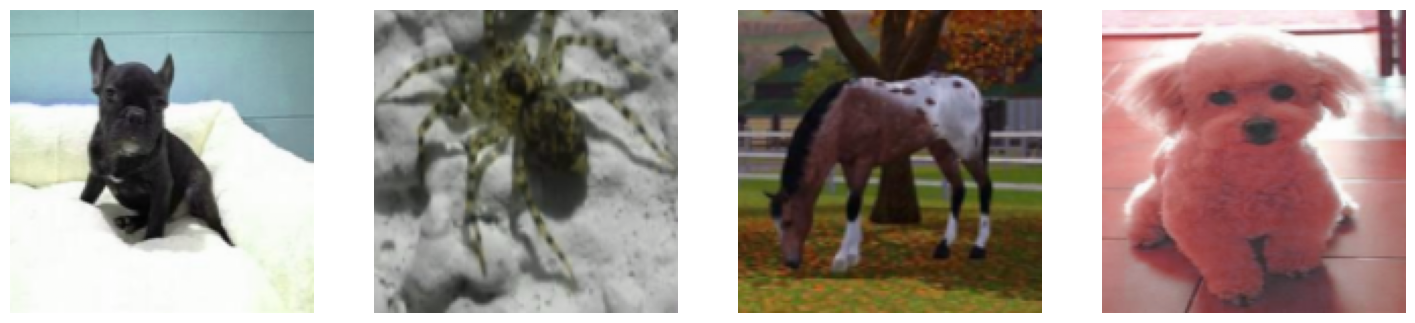

In [12]:
images_ids = np.random.randint(low=0, high=len(train_dataset), size=4)

# Ploteo las imágenes con data augmentation
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    img, label = aug_train_set[images_ids[id]]
    # No es necesario realizar ninguna manipulación de las dimensiones aquí
    row.imshow(img.permute(1, 2, 0))
    row.axis('off')
plt.show()


In [ ]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)
aug_loss = torch.nn.CrossEntropyLoss()
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_data = {"train": aug_train_loader, "test": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "test": SummaryWriter(log_dir="data_aug/aug_test")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                20,
                aug_writer)

In [ ]:
PATH = "./model/aug_conv_model.pt"
torch.save(aug_conv_model, PATH)

In [ ]:
import json
HISTORY_FILE_PATH = "./output/augmented_history.json"
# Writing dictionary to JSON file
with open(HISTORY_FILE_PATH, 'w') as json_file:
    json.dump(history, json_file)

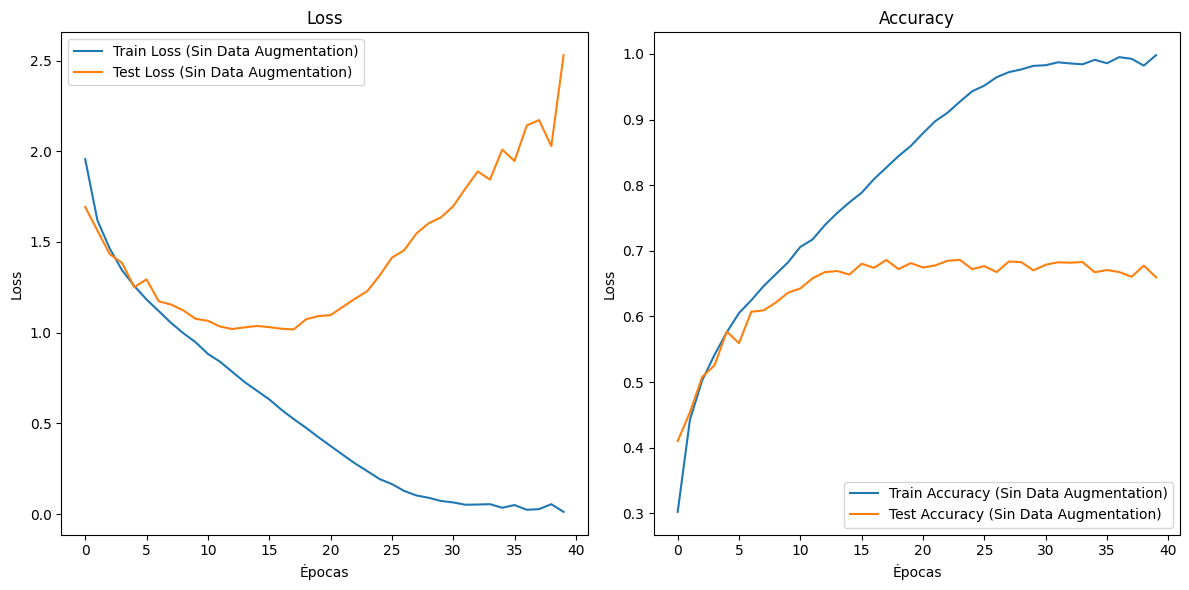

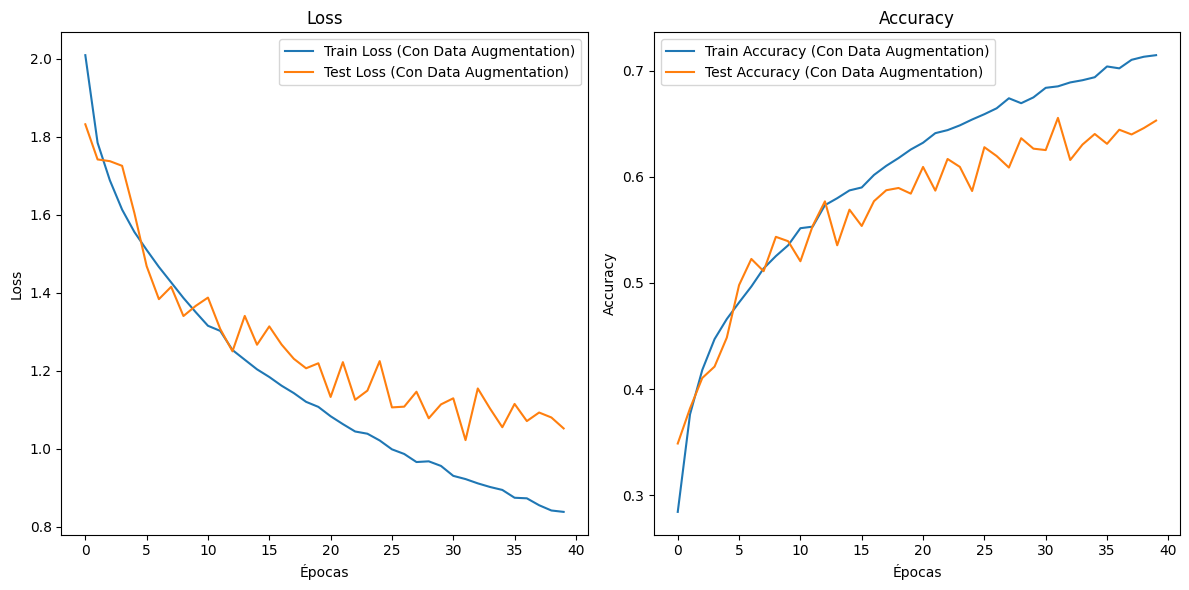

In [5]:
import json
import matplotlib.pyplot as plt

# Cargar métricas sin data augmentation
with open("C:/Users/cbureu/Documents/Repo/CEIA/VCII/output/history.json", "r") as file:
    history = json.load(file)

train_loss = history["train_loss"]
train_acc = history["train_acc"]
valid_loss = history["valid_loss"]
valid_acc = history["valid_acc"]

# Cargar métricas con data augmentation
with open("C:/Users/cbureu/Documents/Repo/CEIA/VCII/output/augmented_history.json", "r") as file:
    augmented_history = json.load(file)

aug_train_loss = augmented_history["train_loss"]
aug_train_acc = augmented_history["train_acc"]
aug_valid_loss = augmented_history["valid_loss"]
aug_valid_acc = augmented_history["valid_acc"]

# Crear subplots para loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss (Sin Data Augmentation)")
plt.plot(valid_loss, label="Test Loss (Sin Data Augmentation)")

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy (Sin Data Augmentation)")
plt.plot(valid_acc, label="Test Accuracy (Sin Data Augmentation)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Crear subplots para accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(aug_train_loss, label="Train Loss (Con Data Augmentation)")
plt.plot(aug_valid_loss, label="Test Loss (Con Data Augmentation)")

plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(aug_train_acc, label="Train Accuracy (Con Data Augmentation)")
plt.plot(aug_valid_acc, label="Test Accuracy (Con Data Augmentation)")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Hiperparametros

In [19]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler


In [14]:
def train(config):
    net = conv_model

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = torch.nn.DataParallel(net)
    net.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(aug_train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(aug_test_loader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total})
    print("Finished Training")

In [15]:
def test_best_model(best_result):
    best_trained_model = conv_model(best_result.config["l1"], best_result.config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in aug_test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

In [16]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
}

In [20]:
num_samples=10
max_num_epochs=10
gpus_per_trial=1

config = {
    "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}
scheduler = ASHAScheduler(
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2
    )
# reporter = CLIReporter(
#     # parameter_columns=["l1", "l2", "lr", "batch_size"],
#     metric_columns=["loss", "accuracy", "training_iteration"])
   
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train),
        resources={"cpu": 2, "gpu": gpus_per_trial}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples,
            
    ),
    param_space=config
)
results = tuner.fit()
   
best_result = results.get_best_result("loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(
    best_result.metrics["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_result.metrics["accuracy"]))

test_best_model(best_result)

2024-04-19 21:22:01,585	INFO worker.py:1752 -- Started a local Ray instance.


: 

## Probar los modelos

In [31]:
from torchvision.io import read_image

In [32]:
# Elegir una imagen aleatoria del conjunto de datos de prueba
random_image_path, true_label = test_dataset[np.random.randint(len(test_dataset))]
random_image = Image.open(random_image_path)

input_image = aug_data_transforms(random_image).unsqueeze(0) 

In [33]:
modelo_ruta = "./model/aug_conv_model.pt"

modelo_cargado = torch.load(modelo_ruta, map_location=torch.device('cpu'))

modelo_cargado.eval()

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [34]:
with torch.no_grad():
    output = modelo_cargado(input_image)
    predicted_class = torch.argmax(output, dim=1).item()

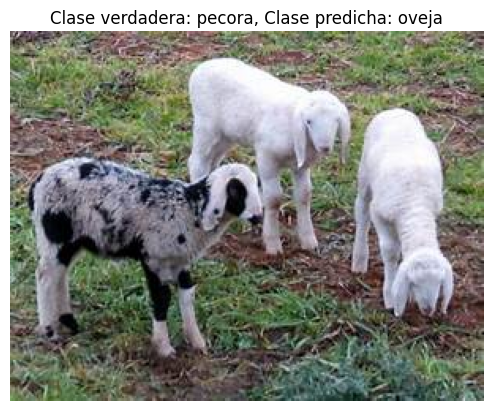

In [35]:
#translate = {1: "perro", 2: "caballo", 3: "elefante", 4: "mariposa", 5: "gallina", 6: "gato", 7: "vaca", 8: "oveja", 9: "araña", 10: "ardilla"}
translate = {0: "perro", 1: "caballo", 2: "elefante", 3: "mariposa", 4: "gallina", 5: "gato", 6: "vaca", 7: "oveja", 8: "araña", 9: "ardilla"}

if predicted_class in translate:
    class_name = translate[predicted_class]
else:
    class_name = "Clase no mapeada"

plt.imshow(random_image)
plt.title(f"Clase verdadera: {true_label}, Clase predicha: {class_name}")
plt.axis('off')
plt.show()

In [36]:
random_image_cata = Image.open("Cata.jpeg")

input_image_cata = aug_data_transforms(random_image_cata).unsqueeze(0) 

In [37]:
with torch.no_grad():
    output = modelo_cargado(input_image_cata)
    predicted_class = torch.argmax(output, dim=1).item()

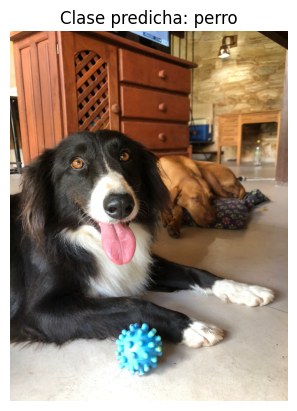

In [39]:
translate = {0: "perro", 1: "caballo", 2: "elefante", 3: "mariposa", 4: "gallina", 5: "gato", 6: "vaca", 7: "oveja", 8: "araña", 9: "ardilla"}

if predicted_class in translate:
    class_name = translate[predicted_class]
else:
    class_name = "Clase no mapeada"

plt.imshow(random_image_cata)
plt.title(f"Clase predicha: {class_name}")
plt.axis('off')
plt.show()